# Gaze Detection

This document will go over our gaze detection component of the system. This pretty much just means this is how we will figureout where people are looking in images.

## Setup

In [7]:
# may be necessary for dlib library, in this order (we had that error at first)

#!pip install cmake
#!pip install face_recognition
#!pip install dlib

In [1]:
# Import necessary libraries
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import dlib


## Facial Landmarks

Our approach is one that detects facial landmarks, and then just uses the eye regions to decide the gaze direction.

First, we are going to download the facial landmarks model.

In [2]:
print("Beginning gaze detection. Step 1: Setting up facial landmark detection")

# Download facial landmark detector model if needed
landmark_model_path = 'models/shape_predictor_68_face_landmarks.dat'

if not os.path.exists(landmark_model_path):
    print("Downloading facial landmark model...")
    !curl -L -o models/shape_predictor_68_face_landmarks.dat.bz2 http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -d models/shape_predictor_68_face_landmarks.dat.bz2
    print("Download complete!")
else:
    print("Facial landmark model already exists!")

Beginning gaze detection. Step 1: Setting up facial landmark detection
Facial landmark model already exists!


## Face Detector

Now, we're going to import the face detector in

In [3]:
model_file = "models/haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(model_file)

## Eye Extraction

Next, we're going to extract eyes from the faces that are detected. We're going to make a function for that for future usage:

In [4]:
# Initialize the face detector and facial landmark predictor
face_detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')

def get_eyes_from_face(face_image, face_rect=None):
    """
    Extract left and right eye images from a face image
    
    Args:
        face_image: RGB image containing a face
        face_rect: Face rectangle coordinates (optional)
        
    Returns:
        left_eye: Left eye image
        right_eye: Right eye image
        eye_centers: Centers of left and right eyes
    """
    # Convert to grayscale for better detection
    gray = cv2.cvtColor(face_image, cv2.COLOR_RGB2GRAY)
    
    # If face_rect is not provided, detect face
    if face_rect is None:
        faces = face_detector(gray)
        if len(faces) == 0:
            print("No face detected")
            return None, None, None
        face_rect = faces[0]  # Use the first detected face
    else:
        # Convert to dlib rectangle format
        x1, y1, x2, y2 = face_rect
        face_rect = dlib.rectangle(x1, y1, x2, y2)
    
    # Get facial landmarks
    landmarks = landmark_predictor(gray, face_rect)
    
    # Extract eye landmarks
    # Left eye points (36-41 in dlib's 68-point model)
    left_eye_points = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(36, 42)])
    
    # Right eye points (42-47 in dlib's 68-point model)
    right_eye_points = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(42, 48)])
    
    # Get eye centers
    left_eye_center = np.mean(left_eye_points, axis=0).astype(int)
    right_eye_center = np.mean(right_eye_points, axis=0).astype(int)
    
    # Get bounding boxes for eyes
    left_eye_x1 = np.min(left_eye_points[:, 0]) - 5
    left_eye_y1 = np.min(left_eye_points[:, 1]) - 5
    left_eye_x2 = np.max(left_eye_points[:, 0]) + 5
    left_eye_y2 = np.max(left_eye_points[:, 1]) + 5
    
    right_eye_x1 = np.min(right_eye_points[:, 0]) - 5
    right_eye_y1 = np.min(right_eye_points[:, 1]) - 5
    right_eye_x2 = np.max(right_eye_points[:, 0]) + 5
    right_eye_y2 = np.max(right_eye_points[:, 1]) + 5
    
    # Ensure coordinates are within image bounds
    h, w = face_image.shape[:2]
    left_eye_x1, left_eye_y1 = max(0, left_eye_x1), max(0, left_eye_y1)
    left_eye_x2, left_eye_y2 = min(w, left_eye_x2), min(h, left_eye_y2)
    right_eye_x1, right_eye_y1 = max(0, right_eye_x1), max(0, right_eye_y1)
    right_eye_x2, right_eye_y2 = min(w, right_eye_x2), min(h, right_eye_y2)
    
    # Extract eye images
    left_eye = face_image[left_eye_y1:left_eye_y2, left_eye_x1:left_eye_x2]
    right_eye = face_image[right_eye_y1:right_eye_y2, right_eye_x1:right_eye_x2]
    
    return left_eye, right_eye, [left_eye_center, right_eye_center]

Now, one for gaze direction:

In [5]:
def estimate_gaze_direction(eye_image):
    """
    Estimate horizontal gaze direction from an eye image
    
    Args:
        eye_image: Image of an eye
        
    Returns:
        gaze_x: Horizontal gaze direction (-1 to 1, where 0 is center)
    """
    if eye_image is None or eye_image.size == 0:
        return 0  # Default: looking straight
    
    # Convert to grayscale
    gray_eye = cv2.cvtColor(eye_image, cv2.COLOR_RGB2GRAY)
    
    # Apply blur and threshold to isolate the pupil
    gray_eye = cv2.GaussianBlur(gray_eye, (7, 7), 0)
    
    # Use adaptive thresholding to handle different lighting conditions
    _, threshold_eye = cv2.threshold(gray_eye, 45, 255, cv2.THRESH_BINARY_INV)
    
    # Find contours in the thresholded image
    contours, _ = cv2.findContours(threshold_eye, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) > 0:
        # Find the largest contour (likely the pupil)
        pupil_contour = max(contours, key=cv2.contourArea)
        
        # Get the centroid of the pupil
        M = cv2.moments(pupil_contour)
        if M["m00"] != 0:
            pupil_x = int(M["m10"] / M["m00"])
            
            # Calculate relative position in the eye (normalize from -1 to 1)
            eye_width = eye_image.shape[1]
            eye_center = eye_width // 2
            
            # Normalize to [-1, 1] where 0 is center
            # Negative means looking left, positive means looking right
            gaze_x = (pupil_x - eye_center) / (eye_width / 2)
            
            # Limit to valid range
            gaze_x = max(-1, min(1, gaze_x))
            
            return gaze_x
    
    # Default: looking straight
    return 0

Now, one for analyzing the gaze overall:

In [6]:
def analyze_gaze(face_image, face_rect=None):
    """
    Analyze gaze direction of a face
    
    Args:
        face_image: RGB image containing a face
        face_rect: Face rectangle coordinates (optional)
        
    Returns:
        gaze_vector: Simplified gaze direction vector [x, y]
        face_with_gaze: Annotated face image showing gaze direction
    """
    # Extract eyes
    left_eye, right_eye, eye_centers = get_eyes_from_face(face_image, face_rect)
    
    if left_eye is None or right_eye is None:
        return [0, 0], face_image  # Default to looking straight ahead
    
    # Get gaze direction for both eyes
    left_gaze = estimate_gaze_direction(left_eye)
    right_gaze = estimate_gaze_direction(right_eye)
    
    # Average the directions
    avg_gaze_x = (left_gaze + right_gaze) / 2
    
    # For simplicity, we'll just use horizontal direction
    # Real gaze would include vertical component too
    gaze_vector = [avg_gaze_x, 0]
    
    # Create annotated image
    face_with_gaze = face_image.copy()
    
    # Draw eyes
    left_center, right_center = eye_centers
    cv2.circle(face_with_gaze, tuple(left_center), 3, (0, 255, 0), -1)
    cv2.circle(face_with_gaze, tuple(right_center), 3, (0, 255, 0), -1)
    
    # Calculate face center (average of both eyes)
    face_center = ((left_center[0] + right_center[0]) // 2, 
                   (left_center[1] + right_center[1]) // 2)
    
    # Draw gaze direction
    gaze_length = 50
    gaze_end = (
        int(face_center[0] + gaze_vector[0] * gaze_length),
        int(face_center[1] + gaze_vector[1] * gaze_length)
    )
    
    cv2.arrowedLine(face_with_gaze, face_center, gaze_end, (0, 0, 255), 2)
    
    return gaze_vector, face_with_gaze

## Testing it out

Using detection parameters:
  - MediaPipe confidence: 0.40
  - Haar min neighbors: 4
  - NMS threshold: 0.55
  - Filter Haar: True
  - Max Haar detections: 10
Running MediaPipe detection...
Running Haar Cascade detection...
Running face_recognition detection...
Detected 13 faces after NMS filtering
No face detected
No face detected
No face detected
No face detected


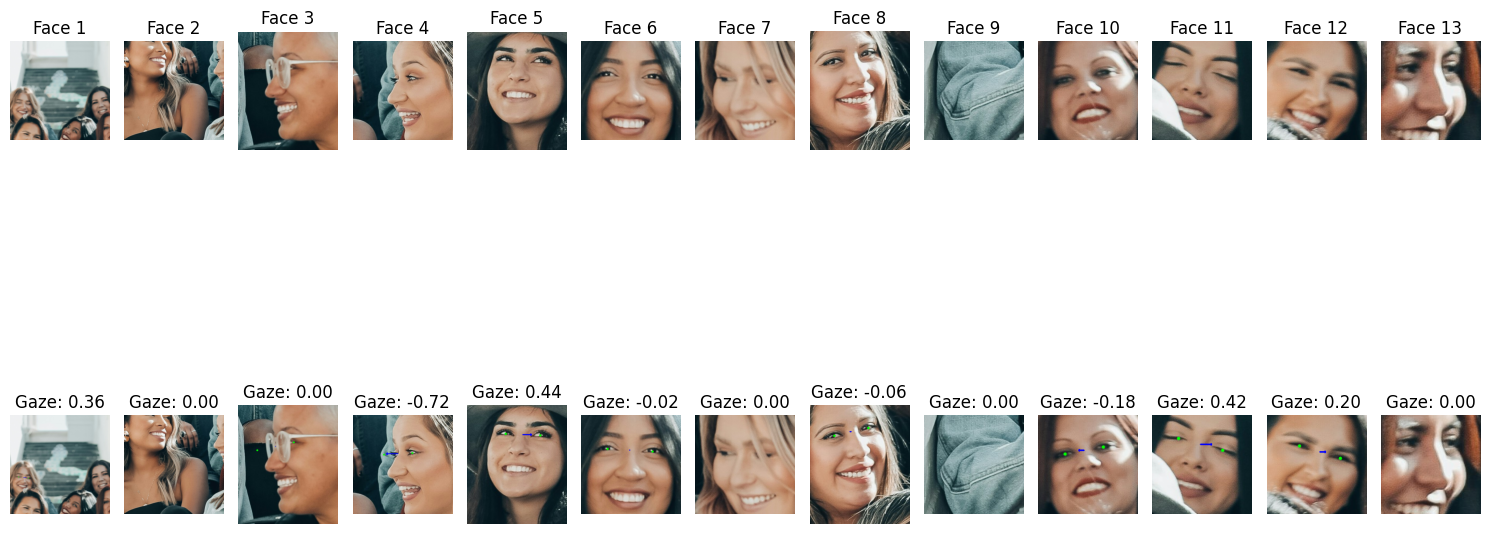

No face detected
No face detected
No face detected
No face detected


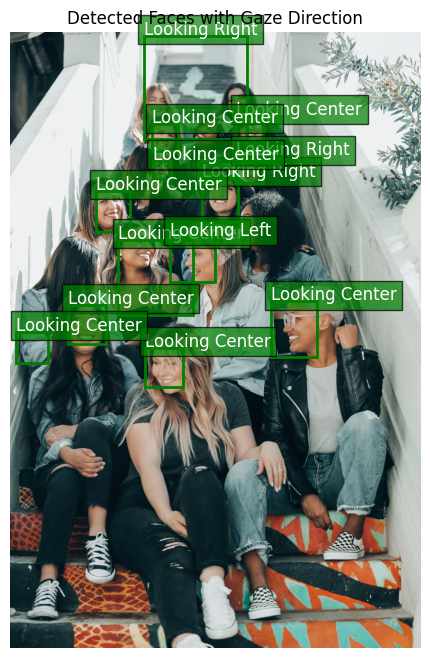

In [ ]:
# Import our face detector
from src.face_utils import detect_faces2



# Test on a sample image
def test_gaze_detection(image_path):
    """Test gaze detection on a face image"""
    
    # Detect faces
    faces, boxes, image = detect_faces2(image_path)
    
    if len(faces) == 0:
        print("No faces detected!")
        return
    
    plt.figure(figsize=(15, 10))
    
    # Process each face
    for i, (face, box) in enumerate(zip(faces, boxes)):
        # Analyze gaze
        gaze_vector, face_with_gaze = analyze_gaze(face)
        
        # Display the result
        plt.subplot(2, len(faces), i + 1)
        plt.imshow(face)
        plt.title(f"Face {i+1}")
        plt.axis("off")
        
        plt.subplot(2, len(faces), i + 1 + len(faces))
        plt.imshow(face_with_gaze)
        plt.title(f"Gaze: {gaze_vector[0]:.2f}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    
    # Show full image with boxes
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    
    # Draw boxes and add gaze info
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        plt.gca().add_patch(
            plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                          fill=False, color='green', linewidth=2)
        )
        
        # Analyze gaze for this face
        gaze_vector, _ = analyze_gaze(faces[i])
        
        # Add text about gaze
        if gaze_vector[0] < -0.2:
            gaze_text = "Looking Left"
        elif gaze_vector[0] > 0.2:
            gaze_text = "Looking Right"
        else:
            gaze_text = "Looking Center"
            
        plt.text(x1, y1-10, gaze_text, color='white', fontsize=12,
                 bbox=dict(facecolor='green', alpha=0.7))
    
    plt.title("Detected Faces with Gaze Direction")
    plt.axis("off")
    plt.show()

# If we have a test images folder, test on one of the images
if os.path.exists('../data2/test_images'):
    test_files = os.listdir('../data2/test_images')
    if len(test_files) > 0:
        test_image = os.path.join('../data2/test_images', test_files[3])
        test_gaze_detection(test_image)
    else:
        print("No test images found!")
else:
    print("Test images folder not found!")

## Analyzing

Creating the analysis function:

In [25]:
def analyze_group_gaze(faces, boxes, positions):
    """
    Analyze gaze interactions between multiple people
    
    Args:
        faces: List of face images
        boxes: List of face bounding boxes
        positions: Positions of faces in the original image
        
    Returns:
        interactions: Dictionary describing gaze interactions
    """
    interactions = []
    gaze_vectors = []
    
    # Get gaze for each face
    for i, face in enumerate(faces):
        gaze_vector, _ = analyze_gaze(face)
        gaze_vectors.append(gaze_vector)
    
    # Calculate center points of each face
    face_centers = []
    for box in boxes:
        x1, y1, x2, y2 = box
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        face_centers.append((center_x, center_y))
    
    # Check if anyone is looking at someone else
    for i, gaze_vector in enumerate(gaze_vectors):
        source_center = face_centers[i]
        
        # Skip if looking straight ahead
        if abs(gaze_vector[0]) < 0.2:
            continue
        
        # Check direction
        looking_right = gaze_vector[0] > 0
        
        # For each other face, check if it's in the gaze direction
        for j, target_center in enumerate(face_centers):
            if i == j:  # Skip self
                continue
                
            # Check if target is in the right direction
            if looking_right and target_center[0] > source_center[0]:
                # Target is to the right, and person is looking right
                interactions.append({
                    'source': i,
                    'target': j,
                    'confidence': abs(gaze_vector[0])
                })
            elif not looking_right and target_center[0] < source_center[0]:
                # Target is to the left, and person is looking left
                interactions.append({
                    'source': i,
                    'target': j,
                    'confidence': abs(gaze_vector[0])
                })
    
    return interactions, gaze_vectors

## Saving functions

In [27]:
# Creating gaze_utils.py

with open('src/gaze_utils.py', 'w') as f:
    f.write("""import cv2
import numpy as np
import dlib

def get_eyes_from_face(face, face_bbox):
    '''
    Extract eye regions from a face image using dlib facial landmarks
    
    Args:
        face: Face image
        face_bbox: Bounding box of face [x1, y1, x2, y2]
    
    Returns:
        left_eye: Left eye image region
        right_eye: Right eye image region
        left_eye_pts: Left eye landmark points
        right_eye_pts: Right eye landmark points
    '''
    # Initialize the dlib facial landmark detector
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")
    
    # Convert bbox to dlib rectangle
    x1, y1, x2, y2 = face_bbox
    dlib_rect = dlib.rectangle(x1, y1, x2, y2)
    
    # Get facial landmarks
    shape = predictor(cv2.cvtColor(face, cv2.COLOR_RGB2GRAY), dlib_rect)
    
    # Extract eye landmarks (36-41 for left eye, 42-47 for right eye)
    left_eye_pts = [(shape.part(i).x, shape.part(i).y) for i in range(36, 42)]
    right_eye_pts = [(shape.part(i).x, shape.part(i).y) for i in range(42, 48)]
    
    # Calculate eye bounding boxes
    left_eye_x = min(pt[0] for pt in left_eye_pts)
    left_eye_y = min(pt[1] for pt in left_eye_pts)
    left_eye_w = max(pt[0] for pt in left_eye_pts) - left_eye_x
    left_eye_h = max(pt[1] for pt in left_eye_pts) - left_eye_y
    
    right_eye_x = min(pt[0] for pt in right_eye_pts)
    right_eye_y = min(pt[1] for pt in right_eye_pts)
    right_eye_w = max(pt[0] for pt in right_eye_pts) - right_eye_x
    right_eye_h = max(pt[1] for pt in right_eye_pts) - right_eye_y
    
    # Add padding
    padding = 5
    left_eye_x = max(0, left_eye_x - padding)
    left_eye_y = max(0, left_eye_y - padding)
    left_eye_w += 2 * padding
    left_eye_h += 2 * padding
    
    right_eye_x = max(0, right_eye_x - padding)
    right_eye_y = max(0, right_eye_y - padding)
    right_eye_w += 2 * padding
    right_eye_h += 2 * padding
    
    # Extract eye regions
    left_eye = face[left_eye_y:left_eye_y+left_eye_h, left_eye_x:left_eye_x+left_eye_w]
    right_eye = face[right_eye_y:right_eye_y+right_eye_h, right_eye_x:right_eye_x+right_eye_w]
    
    # Adjust eye points to be relative to the eye regions
    left_eye_pts = [(x - left_eye_x, y - left_eye_y) for x, y in left_eye_pts]
    right_eye_pts = [(x - right_eye_x, y - right_eye_y) for x, y in right_eye_pts]
    
    return left_eye, right_eye, left_eye_pts, right_eye_pts

def estimate_gaze_direction(eye_region, eye_points):
    '''
    Estimate the gaze direction based on iris position within the eye
    
    Args:
        eye_region: Image of the eye region
        eye_points: Eye landmark points
    
    Returns:
        gaze_direction: Estimated gaze direction as string
        gaze_ratio: Numerical representation of gaze direction
        iris_center: Coordinates of detected iris center
    '''
    # Convert to grayscale
    gray_eye = cv2.cvtColor(eye_region, cv2.COLOR_RGB2GRAY)
    
    # Create mask for eye region
    mask = np.zeros_like(gray_eye)
    cv2.fillPoly(mask, [np.array(eye_points)], 255)
    
    # Apply mask and threshold to isolate iris
    masked_eye = cv2.bitwise_and(gray_eye, gray_eye, mask=mask)
    _, thresholded = cv2.threshold(masked_eye, 50, 255, cv2.THRESH_BINARY_INV)
    
    # Find contours to identify iris
    contours, _ = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Default values if iris detection fails
    iris_center = (eye_region.shape[1] // 2, eye_region.shape[0] // 2)
    gaze_ratio = 1.0
    
    if contours:
        # Get the largest contour (likely the iris)
        iris_contour = max(contours, key=cv2.contourArea)
        
        # Calculate centroid of iris
        M = cv2.moments(iris_contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            iris_center = (cx, cy)
        
        # Calculate eye width from points
        eye_left = min(pt[0] for pt in eye_points)
        eye_right = max(pt[0] for pt in eye_points)
        eye_width = eye_right - eye_left
        
        if eye_width > 0:
            # Calculate position ratio (0 = far left, 1 = center, 2 = far right)
            gaze_ratio = 2.0 * (iris_center[0] - eye_left) / eye_width
    
    # Determine gaze direction
    if gaze_ratio < 0.7:
        gaze_direction = "looking left"
    elif gaze_ratio > 1.3:
        gaze_direction = "looking right"
    else:
        gaze_direction = "looking center"
    
    return gaze_direction, gaze_ratio, iris_center

def analyze_gaze(face, face_bbox):
    '''
    Analyze gaze direction for a single face
    
    Args:
        face: Face image
        face_bbox: Bounding box of face [x1, y1, x2, y2]
    
    Returns:
        gaze_result: Dictionary with gaze analysis results
    '''
    # Extract eye regions
    try:
        left_eye, right_eye, left_eye_pts, right_eye_pts = get_eyes_from_face(face, face_bbox)
    except Exception as e:
        print(f"Error extracting eye regions: {e}")
        return {
            'success': False,
            'direction': "unknown",
            'left_gaze_ratio': None,
            'right_gaze_ratio': None
        }
    
    # Check if eye extraction was successful
    if left_eye.size == 0 or right_eye.size == 0:
        return {
            'success': False,
            'direction': "unknown",
            'left_gaze_ratio': None,
            'right_gaze_ratio': None
        }
    
    # Estimate gaze direction for each eye
    left_direction, left_ratio, left_iris = estimate_gaze_direction(left_eye, left_eye_pts)
    right_direction, right_ratio, right_iris = estimate_gaze_direction(right_eye, right_eye_pts)
    
    # Average the gaze ratios to get overall direction
    avg_ratio = (left_ratio + right_ratio) / 2
    
    # Determine overall gaze direction
    if avg_ratio < 0.7:
        overall_direction = "looking left"
    elif avg_ratio > 1.3:
        overall_direction = "looking right"
    else:
        overall_direction = "looking forward"
    
    # Return results
    return {
        'success': True,
        'direction': overall_direction,
        'left_gaze_ratio': left_ratio,
        'right_gaze_ratio': right_ratio,
        'avg_gaze_ratio': avg_ratio
    }

def analyze_group_gaze(faces, bboxes, face_positions=None):
    '''
    Analyze gaze patterns for a group of faces, including who might be looking at whom
    
    Args:
        faces: List of face images
        bboxes: List of face bounding boxes
        face_positions: Optional list of face center positions in the original image
    
    Returns:
        group_gaze_results: List of dictionaries with gaze analysis and potential targets
    '''
    # Analyze individual gazes
    individual_results = []
    for i, (face, bbox) in enumerate(zip(faces, bboxes)):
        results = analyze_gaze(face, [0, 0, face.shape[1], face.shape[0]])
        results['face_id'] = i
        individual_results.append(results)
    
    # If face positions are provided, estimate who might be looking at whom
    if face_positions is not None:
        for i, result in enumerate(individual_results):
            if not result['success'] or result['direction'] == "looking forward":
                # Can't determine gaze target if looking forward or failed analysis
                result['gaze_target_id'] = -1
                continue
            
            # Get current face position
            current_x, current_y = face_positions[i]
            
            # Determine likely gaze target based on direction and position
            potential_targets = []
            
            for j, (target_x, target_y) in enumerate(face_positions):
                if i == j:  # Skip self
                    continue
                    
                # Calculate angle to target
                dx = target_x - current_x
                dy = target_y - current_y
                
                # Skip targets behind the face if looking forward
                if result['direction'] == "looking left" and dx > 0:
                    continue
                if result['direction'] == "looking right" and dx < 0:
                    continue
                    
                # Calculate distance to target
                distance = np.sqrt(dx**2 + dy**2)
                
                # Add potential target
                potential_targets.append((j, distance))
            
            # Sort by distance and get closest target
            if potential_targets:
                potential_targets.sort(key=lambda x: x[1])
                result['gaze_target_id'] = potential_targets[0][0]
            else:
                result['gaze_target_id'] = -1
    
    return individual_results
""")

print("Gaze detection functions saved to src/gaze_utils.py")

Gaze detection functions saved to src/gaze_utils.py


Ideas for future improved accuracy:
Use pupil tracking algorithms that are more robust to lighting conditions
Train a dedicated gaze estimation neural network
Include head pose estimation to factor in the face orientation
Calibrate the gaze detector for individual users